In [46]:
import os
from os.path import realpath, join
import sys
sys.path.insert(0, '/home/chuah/mitsuba3-camera/build/python')

import drjit as dr
import mitsuba as mi
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

mi.set_variant('cuda_ad_rgb')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
SCENE_DIR = realpath('../tutorials/scenes')

# Make sure that resources from the scene directory can be found
mi.Thread.thread().file_resolver().append(SCENE_DIR)

config = {
        'emitter': 'gray',
        'lens_subdiv_level': 5,
        # 'reference': join(SCENE_DIR, 'references/wave-1024.jpg'),
        # 'render_resolution': (64, 64),
        'render_resolution': (128, 128),
        'spp': 64,
        'max_iterations': 1000,
        # 'learning_rate': 3e-5,
        # 'learning_rate': 3e-3,
        'learning_rate': 3e-4,
    }

# print('[i] Reference image selected:', config['reference'])
# mi.Bitmap(config['reference'])

In [48]:
output_dir = realpath(join('.', 'outputs', 'lens'))
os.makedirs(output_dir, exist_ok=True)
print('[i] Results will be saved to:', output_dir)

[i] Results will be saved to: /home/chuah/mitsuba3-camera/notebooks/outputs/lens


# Set lens parameters

In [49]:
surf0 = {
    'c': -0.3,
    'K': 0.0,
    'z0': 2.5,
}

surf1 = {
    'c': 0.3,
    'K': 0.0,
    'z0': 2.8,
}

# from scripts.lens_design.shapes import compute_z, compute_z_np
# import numpy as np

# rmax = 0.8

# for surf in [surf0, surf1]:
#     z = compute_z(dr.linspace(mi.Float,0,rmax,50), dr.zeros(mi.Float,50), **surf).numpy()
#     plt.plot(z, np.linspace(0,rmax,50))
# plt.axis('equal')

# Mesh generation

In [50]:
from scripts.lens_design.geometry import create_lens_element
from scripts.lens_design.shapes import compute_z_np
import numpy as np
from functools import partial

def create_mesh(V: np.ndarray, F: np.ndarray, name: str):
    Nv = V.shape[0]
    Nf = F.shape[0]

    # Convert vertices and faces
    V = mi.Vector3f(V)
    F = mi.Vector3u(F)

    # Instantiate the mesh object
    mesh = mi.Mesh(name, Nv, Nf, has_vertex_texcoords=False)

    # Set its buffers
    mesh_params = mi.traverse(mesh)
    mesh_params['vertex_positions'] = dr.ravel(V)
    mesh_params['faces'] = dr.ravel(F)
    mesh_params.update()

    return mesh


def initialize_lens_geometry(subdiv_lvl: int, radius_surf0: float, radius_surf1: float):
    V_lens, F_lens, V_ap, F_ap, film_mask, world_mask = create_lens_element(
        N=subdiv_lvl,
        r_film  = radius_surf0,
        r_world = radius_surf1,
        z_film  = partial(compute_z_np, **surf0),
        z_world = partial(compute_z_np, **surf1),
    )
    
    lens_mesh = create_mesh(V_lens, F_lens, "lens")
    ap_mesh   = create_mesh(V_ap, F_ap, "aperture")
    film_mask  = mi.Mask(film_mask)
    world_mask = mi.Mask(world_mask)

    return lens_mesh, ap_mesh, film_mask, world_mask
    
lens_res = config.get('lens_res', config['lens_subdiv_level'])
element_id = 0
lens_fname = join(output_dir, 'lens{}.ply'.format(element_id))
ap_fname = join(output_dir, 'ap{}.ply'.format(element_id))

lens_mesh, ap_mesh, lens_film_mask, lens_world_mask = initialize_lens_geometry(lens_res, 0.8, 0.8)
lens_mesh.write_ply(lens_fname)
ap_mesh.write_ply(ap_fname)
print('[+] Wrote lens mesh (subdivs={}) file to: {}'.format(lens_res, lens_fname))

V_ lies on sphere: True
V_ lies on sphere: True
[+] Wrote lens mesh (subdivs=5) file to: /home/chuah/mitsuba3-camera/notebooks/outputs/lens/lens0.ply


In [51]:
from igl import read_triangle_mesh
import meshplot as mp

# p_ = mp.plot(*read_triangle_mesh('/home/chuah/mitsuba3-camera/notebooks/outputs/wave/lens_128_128.ply'))
# mp.plot(*read_triangle_mesh('/home/chuah/mitsuba3-camera/tutorials/scenes/meshes/slab.obj'), c=np.array([0,1,0]))
# p_ = mp.plot(*read_triangle_mesh('/home/chuah/mitsuba3-camera/notebooks/outputs/lens/lens0.ply'), shading={"wireframe": True})
# p_.add_mesh(*read_triangle_mesh('/home/chuah/mitsuba3-camera/notebooks/outputs/lens/ap0.ply'))

# Emitter creation

In [52]:
emitter = {
    'type':'directionalarea',
    'radiance': {
        'type': 'spectrum',
        'value': 0.05
    },
}

# Create the integrator

In [53]:
integrator = {
    'type': 'ptracer',
    'samples_per_pass': 256,    # TODO: prb?
    'max_depth': 4,
    'hide_emitters': False,
}

# Assemble the scene

In [54]:
# Looking at the receiving plane, not looking through the lens
# TODO: set axial positions appropriately
# - film plane (OK)
# - emitter (arbitrary, set to max{z0})
# - camera (OK, but might need to be adjusted per-problem)

z_sensor = surf0['z0'] - 0.1
sensor_to_world = mi.ScalarTransform4f.look_at(
    # target=[0, 0, -20],
    # origin=[0, 0, -4.65],
    # up=[0, 1, 0]
    target=[0, 0, -20],
    origin=[0, 0, 0.5],
    up=[0, 1, 0]
)

resx, resy = config['render_resolution']
sensor = {
    'type': 'perspective',
    'near_clip': 0.1,
    'far_clip': 100,
    'fov': 45,
    'to_world': sensor_to_world,

    'sampler': {
        'type': 'independent',
        'sample_count': 512  # Not really used
    },
    'film': {
        'type': 'hdrfilm',
        'width': resx,
        'height': resy,
        'pixel_format': 'rgb',
        'rfilter': {
            # Important: smooth reconstruction filter with a footprint larger than 1 pixel.
            'type': 'gaussian'
        }
    },
}

Define the full scene

In [55]:
scene = {
    'type': 'scene',
    'sensor': sensor,
    'integrator': integrator,
    # Glass BSDF
    'simple-glass': {                   # TODO: dispersive model
        'type': 'dielectric',
        'id': 'simple-glass-bsdf',
        'ext_ior': 'air',
        'int_ior': 1.5,
        'specular_reflectance': { 'type': 'spectrum', 'value': 0 },
    },
    'white-bsdf': {
        'type': 'diffuse',
        'id': 'white-bsdf',
        'reflectance': { 'type': 'rgb', 'value': (1, 1, 1) },
    },
    'black-bsdf': {
        'type': 'diffuse',
        'id': 'black-bsdf',
        'reflectance': { 'type': 'spectrum', 'value': 0 },
    },
    # Receiving plane
    'receiving_plane': {
        'type': 'obj',
        'id': 'receiving_plane',
        'filename': 'meshes/rectangle.obj',
        'to_world': \
            mi.ScalarTransform4f.look_at(
                target=[0, 0, 1],
                origin=[0, 0, 0],
                up=[0, 1, 0]
                # target=[0, 0, 1],
                # origin=[0, 0, -7],
                # up=[0, 1, 0]
            ).scale((5, 5, 5)),
        'bsdf': {'type': 'ref', 'id': 'white-bsdf'},
    },
    # ELEMENT 1
    # lens element
    'lens': {
        'type': 'ply',
        'id': 'lens',
        'filename': lens_fname,
        'bsdf': {'type': 'ref', 'id': 'simple-glass'},
    },
    # baffle element
    'baffle': {
        'type': 'ply',
        'id': 'ap',
        'filename': ap_fname,
        'bsdf': {'type': 'ref', 'id': 'black-bsdf'},
    },
    # TODO: handle multiple lenses

    # Ray source: directional area emitter
    # TODO: choose correct size: scales with aperture
    # TODO: choose correct direction: diff angles for different fields
    'focused-emitter-shape': {
        'type': 'obj',
        'filename': 'meshes/circle.obj',
        'to_world': mi.ScalarTransform4f.look_at(
            target=[0, 0, 0],
            origin=[0, 0, 10],
            up=[0, 1, 0]
            # target=[0, 0, 0],
            # origin=[0, 0, 5],
            # up=[0, 1, 0]
        ),
        'bsdf': {'type': 'ref', 'id': 'black-bsdf'},
        'focused-emitter': emitter,
    },
}

scene = mi.load_dict(scene)

2024-04-29 12:52:30 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


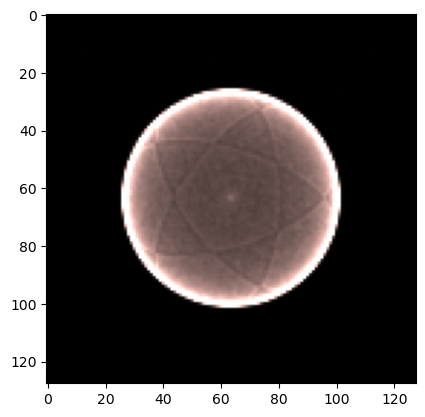

In [56]:
image_init = mi.render(scene, spp=512)
plt.imshow(image_init)

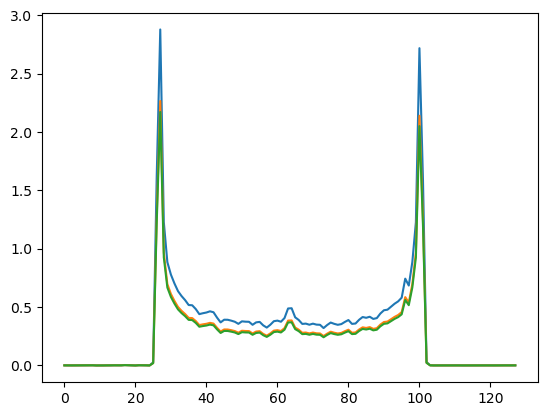

In [57]:
spot_init = image_init.numpy()[config['render_resolution'][0] // 2]
plt.plot(spot_init)

# Load the reference image

In [58]:
# def load_ref_image(config, resolution, output_dir):
#     b = mi.Bitmap(config['reference'])
#     b = b.convert(mi.Bitmap.PixelFormat.RGB, mi.Bitmap.Float32, False)
#     if b.size() != resolution:
#         b = b.resample(resolution)

#     mi.util.write_bitmap(join(output_dir, 'out_ref.exr'), b)

#     print('[i] Loaded reference image from:', config['reference'])
#     return mi.TensorXf(b)

# # Make sure the reference image will have a resolution matching the sensor
# sensor = scene.sensors()[0]
# crop_size = sensor.film().crop_size()
# image_ref = load_ref_image(config, crop_size, output_dir=output_dir)

In [59]:
# initial_heightmap_resolution = [r // (2 ** config['n_upsampling_steps'])
#                                 for r in (128, 128)]
# upsampling_steps = dr.sqr(dr.linspace(mi.Float, 0, 1, config['n_upsampling_steps']+1, endpoint=False).numpy()[1:])
# upsampling_steps = (config['max_iterations'] * upsampling_steps).astype(int)
# print('The resolution of the heightfield will be doubled at iterations:', upsampling_steps)

# heightmap_texture = mi.load_dict({
#     'type': 'bitmap',
#     'id': 'heightmap_texture',
#     'bitmap': mi.Bitmap(dr.zeros(mi.TensorXf, initial_heightmap_resolution)),
#     'raw': True,
# })

# # Actually optimized: the heightmap texture
# params = mi.traverse(heightmap_texture)
# params.keep(['data'])
# opt = mi.ad.Adam(lr=config['learning_rate'], params=params)

# Applying the displacement texture

In [60]:
# params_scene = mi.traverse(scene)

# # We will always apply displacements along the original normals and
# # starting from the original positions.
# positions_initial = dr.unravel(mi.Vector3f, params_scene['lens.vertex_positions'])
# normals_initial   = dr.unravel(mi.Vector3f, params_scene['lens.vertex_normals'])

# lens_si = dr.zeros(mi.SurfaceInteraction3f, dr.width(positions_initial))
# lens_si.uv = dr.unravel(type(lens_si.uv), params_scene['lens.vertex_texcoords'])

# def apply_displacement(amplitude = 1.):
#     # Enforce reasonable range. For reference, the receiving plane
#     # is 7 scene units away from the lens.
#     vmax = 1 / 100.
#     params['data'] = dr.clamp(params['data'], -vmax, vmax)
#     dr.enable_grad(params['data'])

#     height_values = heightmap_texture.eval_1(lens_si)
#     new_positions = (height_values * normals_initial * amplitude + positions_initial)
#     params_scene['lens.vertex_positions'] = dr.ravel(new_positions)
#     params_scene.update()

from scripts.lens_design.shapes import compute_z

params_scene = mi.traverse(scene)
opt = mi.ad.Adam(lr=config['learning_rate'])

# TODO: currently only updating curvature
opt['c'] = mi.Float(surf0['c'])     
opt['K'] = mi.Float(surf0['K'])
opt.set_learning_rate({
    'c': config['learning_rate'], 
    'K': 1e-1 * config['learning_rate'],
    })

initial_vertex_pos = dr.unravel(mi.Point3f, params_scene['lens.vertex_positions'])

# Now we define the update rule
def update_vertex_pos(params: mi.SceneParameters, optimizer: mi.ad.optimizers.Optimizer) -> None:
    # Compute new vertex positions
    new_vertex_pos = mi.Point3f(
            initial_vertex_pos[0], 
            initial_vertex_pos[1], 
            dr.select(lens_film_mask, 
                      compute_z(
                        initial_vertex_pos[0], 
                        initial_vertex_pos[1], 
                        # c  = surf0['c'], 
                        # K  = surf0['K'],
                        z0 = surf0['z0'],
                        c  = optimizer['c'],
                        K  = optimizer['K'],
                        # z0=optimizer['z0']
                        ),
                     initial_vertex_pos[2]),
                     )

    # TODO: update baffle positions

    # Flatten the vertex position array before assigning it to `params`
    params['lens.vertex_positions'] = dr.ravel(new_vertex_pos)

    # # Propagate changes through the scene (e.g. rebuild BVH)
    params.update()

In [61]:
from scripts.lens_design.geometry import meshplot_gizmo
from gpytoolbox import cone

def draw_camera(sensor_to_world):
    # plot sensor as a +z-facing cone
    V, F = cone(16,2)
    V += np.array([[0,0,-1]])
    V *= -1

    # apply camera-to-world transform
    V = (sensor_to_world @ mi.Point3f(V)).numpy()
    p_ = mp.plot(V,F)
    meshplot_gizmo(p_)
    return p_

def meshplot_scene(params):
    p_ = draw_camera(params['sensor.to_world'])
    meshes = ['focused-emitter-shape', 'ap', 'lens', 'receiving_plane']
    for mesh in meshes:
        V = dr.unravel(mi.Point3f, params[f'{mesh}.vertex_positions']).numpy()
        F = dr.unravel(mi.Point3u, params[f'{mesh}.faces']).numpy()
        p_.add_mesh(V, F, shading={"wireframe": True})
    return p_

# meshplot_scene(params_scene)



# Optimization

In [62]:
# def scale_independent_loss(image, ref):
#     """Brightness-independent L2 loss function."""
#     scaled_image = image / dr.mean(dr.detach(image))
#     scaled_ref = ref / dr.mean(ref)
#     return dr.mean(dr.sqr(scaled_image - scaled_ref))

# TODO: further validation of this loss
def rms_loss(image):
    scaled_image = image / dr.mean(dr.detach(image))
    i = dr.arange(mi.Float, image.shape[0])
    j = dr.arange(mi.Float, image.shape[1])
    ii, jj = dr.meshgrid(i, j, indexing='ij')
    # ibar = dr.mean(ii * scaled_image) / dr.mean(scaled_image)
    # jbar = dr.mean(jj * scaled_image) / dr.mean(scaled_image)
    # print(scaled_image[:,:,0] * (dr.sqr(ii - image.shape[0] / 2) + dr.sqr(jj - image.shape[1] / 2)))
    I = scaled_image[:,:,0]
    rms = dr.sum(I * (dr.sqr(ii - image.shape[0] / 2) + dr.sqr(jj - image.shape[1] / 2))) * dr.rcp(dr.sum(I))
    # rms *= dr.rcp(image.shape[0] * image.shape[1])
    return rms

In [63]:
print(rms_loss(image_init))

[976.3732299804688]


In [64]:
# V_curr = dr.unravel(mi.Point3f, params_scene['lens.vertex_positions'])
# F = read_triangle_mesh('/home/chuah/mitsuba3-camera/notebooks/outputs/lens/lens0.ply')[1]
# mp.plot(V_curr.numpy(), F)

In [65]:
# # Apply displacement and update the scene BHV accordingly
# update_vertex_pos()

# # Perform a differentiable rendering of the scene
# image = mi.render(scene, params_scene, spp=2*512, spp_grad=512)

# # Scale-independent L2 function
# loss = scale_independent_loss(image, image_ref)
# dr.backward(loss)

# print(opt['c'])
# opt.step()

# print(opt['c'])

In [66]:
import time
start_time = time.time()
mi.set_log_level(mi.LogLevel.Warn)
iterations = config['max_iterations']
loss_values = []
spp = config['spp']

for it in range(iterations):
    t0 = time.time()

    # Apply displacement and update the scene BHV accordingly
    update_vertex_pos(params_scene, opt)

    # Perform a differentiable rendering of the scene
    image = mi.render(scene, params_scene, seed=it, spp=2 * spp, spp_grad=spp)

    # Scale-independent L2 function
    # loss = scale_independent_loss(image, image_ref)
    loss = rms_loss(image)

    # Back-propagate errors to input parameters and take an optimizer step
    dr.backward(loss)

    # Take a gradient step
    opt.step()

    # # Increase resolution of the heightmap
    # if it in upsampling_steps:
    #     opt['data'] = dr.upsample(opt['data'], scale_factor=(2, 2, 1))

    # Carry over the update to our "latent variable" (the heightmap values)
    # TODO: does this do anything?
    params_scene.update(opt)

    # Log progress
    elapsed_ms = 1000. * (time.time() - t0)
    current_loss = loss[0]
    loss_values.append(current_loss)
    mi.Thread.thread().logger().log_progress(
        it / (iterations-1),
        f'Iteration {it:03d}: loss={current_loss:g} (took {elapsed_ms:.0f}ms)',
        'Caustic Optimization', '')


    # Increase rendering quality toward the end of the optimization
    if it in (int(0.7 * iterations), int(0.9 * iterations)):
        spp *= 2
        opt.set_learning_rate(0.5 * opt.lr['c'])
        opt.set_learning_rate(0.5 * opt.lr['K'])


end_time = time.time()
print(((end_time - start_time) * 1000) / iterations, ' ms per iteration on average')
mi.set_log_level(mi.LogLevel.Info)

2024-04-29 12:53:01 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:01 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:01 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:01 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:02 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:02 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:02 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:02 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:02 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:02 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:02 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:02 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:02 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:02 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:02 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:02 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:02 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:02 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:02 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:02 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:03 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:03 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:03 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:03 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:03 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:03 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:03 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:03 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:03 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:03 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:03 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:03 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:03 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:03 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:03 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:03 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:04 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:04 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:04 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:04 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:04 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:04 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:04 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:04 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:04 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:04 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:04 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:04 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:04 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:04 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:04 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:05 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:05 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:05 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:05 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:05 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:05 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:05 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:05 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:05 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:05 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:05 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:05 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:05 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:05 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:05 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:05 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:06 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:06 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:06 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:06 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:06 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:06 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:06 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:06 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:06 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:06 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:06 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:06 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:06 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:06 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:06 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:06 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:07 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:07 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:07 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:07 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:07 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:07 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:07 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:07 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:07 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:07 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:07 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:07 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:07 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:07 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:07 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-04-29 12:53:07 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

36.3553626537323  ms per iteration on average


In [67]:
# fname = join(output_dir, 'heightmap_final.exr')
# mi.util.write_bitmap(fname, params['data'])
# print('[+] Saved final heightmap state to:', fname)

# fname = join(output_dir, 'lens_displaced.ply')
# apply_displacement()
# lens_mesh = [m for m in scene.shapes() if m.id() == 'lens'][0]
# lens_mesh.write_ply(fname)
# print('[+] Saved displaced lens to:', fname)

# Visualization

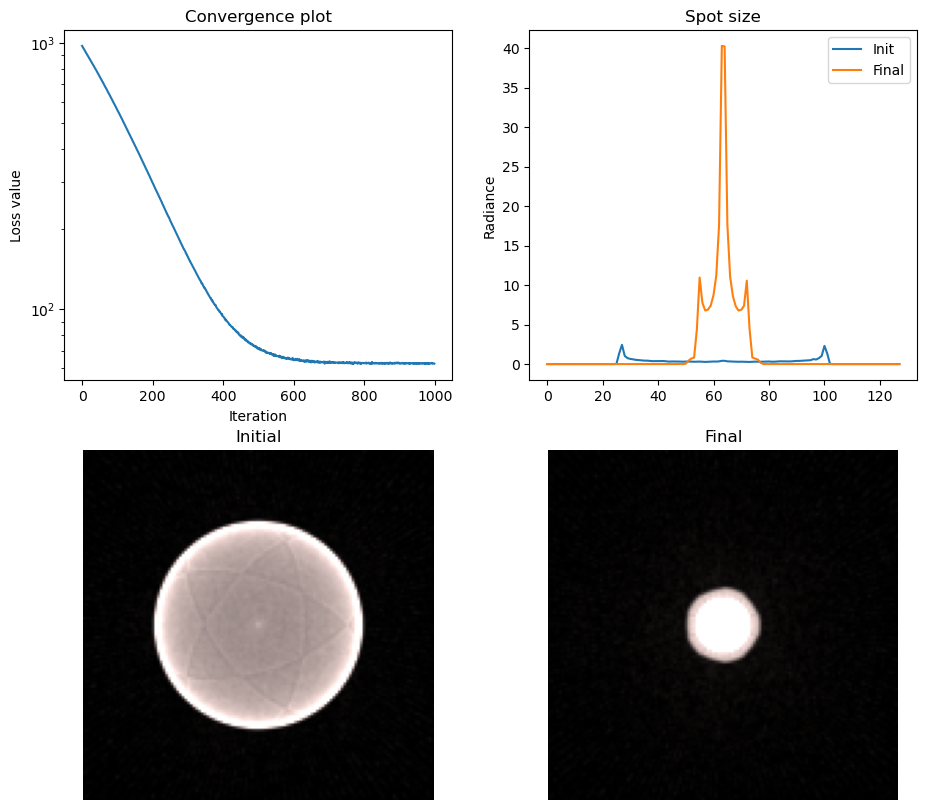

In [68]:
import matplotlib.pyplot as plt

def show_image(ax, img, title):
    ax.imshow(mi.util.convert_to_bitmap(img))
    ax.axis('off')
    ax.set_title(title)

def show_heightmap(fig, ax, values, title):
    im = ax.imshow(values.squeeze(), vmax=1e-4)
    fig.colorbar(im, ax=ax)
    ax.axis('off')
    ax.set_title(title)

fig, ax = plt.subplots(2, 2, figsize=(11, 10))
ax = ax.ravel()
ax[0].semilogy(loss_values)
ax[0].set_xlabel('Iteration'); ax[0].set_ylabel('Loss value'); ax[0].set_title('Convergence plot')

spot_final = image.numpy()[config['render_resolution'][0] // 2]
ax[1].plot(np.mean(spot_init,axis=1), label="Init")
ax[1].plot(np.mean(spot_final,axis=1), label="Final")
ax[1].set_title('Spot size')
ax[1].set_ylabel("Radiance")
ax[1].legend()

show_image(ax[2], image_init, 'Initial')
show_image(ax[3], image,     'Final')
plt.show()

In [69]:
print(opt['K'], opt['c'])
V_curr = dr.unravel(mi.Point3f, params_scene['lens.vertex_positions'])
F = read_triangle_mesh('/home/chuah/mitsuba3-camera/notebooks/outputs/lens/lens0.ply')[1]
mp.plot(V_curr.numpy(), F)

[0.006087734363973141] [-0.40306153893470764]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


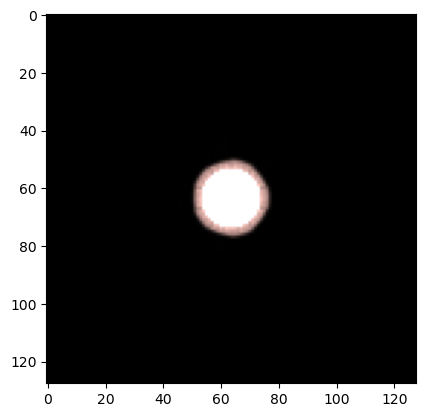

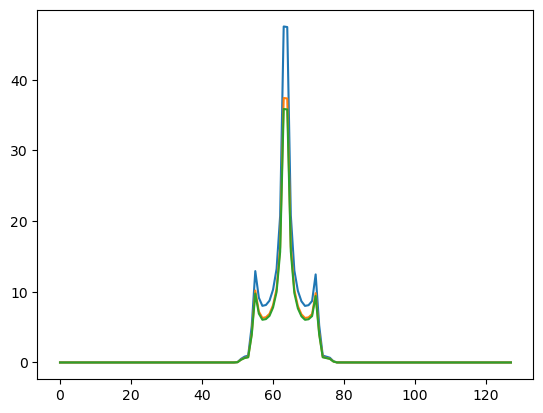

In [93]:
image_final = image.numpy()
spot_final = image_final[config['render_resolution'][0] // 2]
plt.imshow(image_final)
plt.figure()
plt.plot(spot_final)